In [1]:
import matplotlib.pyplot as plt
import numpy as np

from datasets.mnist import MNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn

from cem import ContrastiveExplanationMethod

In [2]:
dataset = MNIST(batch_size=64)
# dataset = FashionMNIST()

# Training the classifier

In [3]:
cnn = CNN(device="cpu")

train_cnn(cnn, dataset, iterations=20, lr=0.01, save_fn='mnist-cnn', device="cpu", load_path="models/saved_models/mnist-cnn.h5")

In [4]:
images, _ = dataset.get_batch()

output = cnn(images)

images = images.numpy()
output = output.detach().numpy()


D:\david\Coding\uva-fact-ai\models\conv_model.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(out)


# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [5]:
# Train or load autoencoder
cae = CAE(device="cpu")

train_ae(cae, dataset, iterations=10, save_fn="mnist-cae", device="cpu", load_path="models/saved_models/mnist-cae-no-rs.h5")

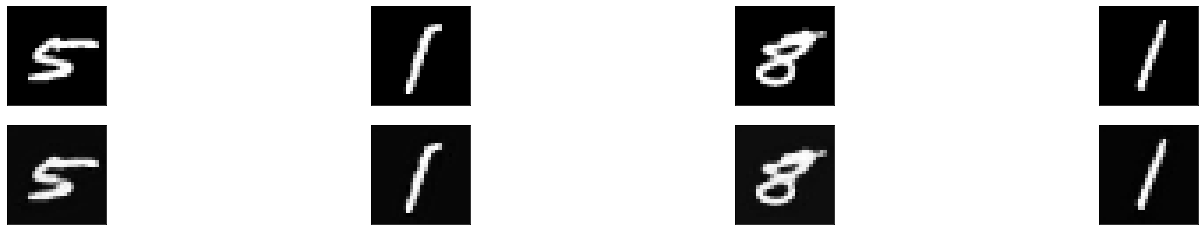

In [6]:
# obtain one batch of test images
images, _ = dataset.get_batch()

#images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = cae(images + .5)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
# output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Contrastive Explanation Method

In [7]:
CEM = ContrastiveExplanationMethod(cnn, cae, iterations=100, n_searches=4, kappa=0., gamma=10., beta=10., learning_rate=0)

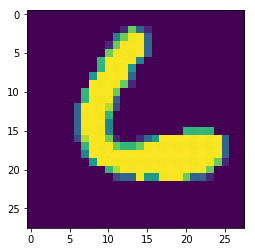

In [8]:
# obtain one sample
image, _ = dataset.get_sample()

plt.imshow(image.squeeze())

In [9]:
# find pertinent negatives
CEM.fista(image, mode="PN")

search:0 iteration:0 lr:0.10 c value:10.00 loss: 6644.43 delta sum:0.00 optimum:False y grad:-12241.587
search:0 iteration:20 lr:0.09 c value:10.00 loss: 15718.38 delta sum:-247.45 optimum:False y grad:-21157.227
search:0 iteration:40 lr:0.08 c value:10.00 loss: 15718.38 delta sum:-247.45 optimum:False y grad:-21157.227
search:0 iteration:60 lr:0.06 c value:10.00 loss: 15718.38 delta sum:-247.45 optimum:False y grad:-21157.227
search:0 iteration:80 lr:0.04 c value:10.00 loss: 15718.38 delta sum:-247.45 optimum:False y grad:-21157.227
search:1 iteration:0 lr:0.10 c value:100.00 loss: 8646.15 delta sum:0.00 optimum:False y grad:-9020.335
search:1 iteration:20 lr:0.09 c value:100.00 loss: 17045.08 delta sum:-238.23 optimum:False y grad:-17910.051
search:1 iteration:40 lr:0.08 c value:100.00 loss: 17354.46 delta sum:-239.95 optimum:False y grad:-17840.369
search:1 iteration:60 lr:0.06 c value:100.00 loss: 17623.74 delta sum:-241.70 optimum:False y grad:-17817.625
search:1 iteration:80 lr:0

In [10]:
print(CEM.best_delta - image.view(28*28))

TypeError: rsub() received an invalid combination of arguments - got (Tensor, NoneType), but expected one of:
 * (Tensor input, Tensor other, Number alpha)
 * (Tensor input, Number other, Number alpha)


In [ ]:
plt.imshow(image.squeeze())

In [ ]:
# perturbation
plt.imshow(CEM.best_delta.view(28,28) - image.squeeze())

In [ ]:
# original image with perturbation
plt.imshow(CEM.best_delta.view(28,28))

In [ ]:
# classification after
np.argmax(cnn(CEM.best_delta.view(1,28,28)).detach())

In [ ]:
# classification before
np.argmax(cnn(image.squeeze(-1)).detach())

In [ ]:
print(CEM.best_loss)

In [ ]:
print(CEM.best_pert_loss)

In [ ]:
print(image)